# KNN-Classifier

In [1]:
# Import Packages
from Code.find_path_nextcloud import find_path_nextcloud
import matplotlib.pyplot as plt
import spectral as spy
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from numpy import unique
from sklearn.metrics import confusion_matrix
import time

In [2]:
path_nextcloud = find_path_nextcloud()
path_labeled = path_nextcloud + 'Daten_Gyrocopter/Oldenburg/Teilbilder/grid_200_200/labeled/'

Daten als DataFrame einlesen

In [3]:
from Code.image_functions import *
df_annotations = import_labeled_data(path_labeled_folder=path_labeled)
df_annotations['label'] = df_annotations['label'].replace({0:'None',1:'Wiese', 2:'Straße',3: 'Auto', 4:'See', 5:'Schienen', 6:'Haus', 7:'Wald'})

In [4]:
df_annotations.iloc[:3,:5]

,hsi_band_430_nm,hsi_band_434_nm,hsi_band_439_nm,hsi_band_443_nm,hsi_band_448_nm
0,1314.0,1369.0,1487.0,1572.0,1614.0
1,1301.0,1389.0,1501.0,1557.0,1679.0
2,1362.0,1494.0,1543.0,1546.0,1649.0


In [5]:
df_annotations.iloc[:3,-5:]

,hsi_band_925_nm,thermal,dom,label,picture_name
0,2554.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_
1,2551.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_
2,2579.0,0.0,0.0,None,Teilbild_Oldenburg_00000000_00000000_0_0_


Aufteilung in Trainings- und Testdaten

In [6]:
X = df_annotations.drop(columns=['label', 'picture_name'])
Y = df_annotations['label']

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3)

## KNN

Laufzeit in Sekunden 1036.5
Accuracy: 76.18869047619047
              precision    recall  f1-score   support

        Auto       0.65      0.25      0.36      2874
        Haus       0.85      0.77      0.81     33544
        None       0.76      0.79      0.77     59360
    Schienen       0.84      0.75      0.79      1358
         See       0.99      0.99      0.99      7419
        Wald       0.68      0.82      0.74     29869
       Wiese       0.73      0.65      0.69     33576

    accuracy                           0.76    168000
   macro avg       0.79      0.72      0.74    168000
weighted avg       0.77      0.76      0.76    168000



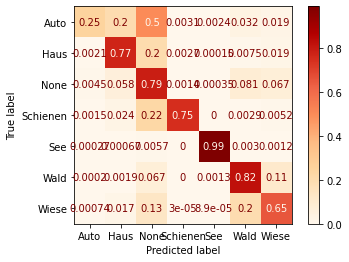

In [9]:
# save start time
start = time.process_time()

# Train
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

# Test
knn_pred = knn.predict(X_test)

# save end time
end = time.process_time()

# calculate runtime
run_time = end - start


# Result
print(f'Laufzeit: {run_time.__round__(1)}s')
print(f"Accuracy: {accuracy_score(y_test, knn_pred) * 100}")
print(classification_report(y_test, knn_pred))
cm = confusion_matrix(y_test, knn_pred, labels=list(unique(knn_pred)), normalize='true')
disp = ConfusionMatrixDisplay(cm, display_labels=list(unique(knn_pred)))
disp.plot(cmap="OrRd")

### KNN mit Grid-Search

In [8]:
from sklearn.model_selection import GridSearchCV
import time

In [11]:
parameters = {'n_neighbors':[1,5,10,20,30], 'weights':['uniform', 'distance'], 'p':[2]}

classifier = GridSearchCV(estimator = KNeighborsClassifier(n_jobs=5),
                          param_grid = parameters,
                          scoring = "f1_macro",
                          n_jobs = -1,
                          refit = True,
                          cv = 2, # Crossvalidation k-folds
                          verbose = 3,
                          pre_dispatch ='2*n_jobs',
                          error_score = np.nan,
                          return_train_score = False)


In [ ]:
start = time.process_time()
classifier.fit(X=X, y=Y)
end = time.process_time()

run_time = end - start
print(f'Laufzeit: {run_time.__round__(1)}s')

In [13]:
df = pd.DataFrame(classifier.cv_results_)
df.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,param_weights,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,1.979184,0.010469,1396.597473,18.642152,1,2,uniform,"{'n_neighbors': 1, 'p': 2, 'weights': 'uniform'}",0.547485,0.575717,0.561601,0.014116,9
1,2.023572,0.027944,1363.865004,41.031280,1,2,distance,"{'n_neighbors': 1, 'p': 2, 'weights': 'distance'}",0.547485,0.575717,0.561601,0.014116,9
2,2.112352,0.120678,1351.799765,22.754651,5,2,uniform,"{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}",0.562000,0.607505,0.584753,0.022753,8
3,2.453942,0.031415,1359.034916,32.813254,5,2,distance,"{'n_neighbors': 5, 'p': 2, 'weights': 'distance'}",0.569603,0.610203,0.589903,0.020300,7
4,2.500812,0.069314,1384.970073,26.073777,10,2,uniform,"{'n_neighbors': 10, 'p': 2, 'weights': 'uniform'}",0.573162,0.623712,0.598437,0.025275,6


In [18]:
df.to_csv(path_or_buf='data/KNN_GridSearch.csv', sep=';', encoding='utf8')

In [19]:
classifier.best_estimator_

KNeighborsClassifier(n_jobs=5, n_neighbors=20, weights='distance')

In [20]:
classifier.best_score_

0.6046059210693627